# SMS Spam Collection Dataset

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.
The files contain one message per line. v1 contains the label (ham or spam) and v2 contains the raw text.

The dataset is taken from kaggle.

In [28]:
# Importing libraries

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB

## 1. Data Preparation

In [29]:
# Load the dataset
df = pd.read_csv('spam.csv',encoding='latin-1') #if encoding not provided gives error UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 135-136: invalid continuation byte
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [30]:
#Dropping unnecessary columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
#Replacing column names
df.rename(columns={'v1':'label','v2':'sms'},inplace=True)

In [32]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

## 2. Exploratory Data Analysis

In [33]:
df.groupby('label').describe()

sms
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

#### Inference
We can see the top msgs in ham and spam. Please call our customer service rep seems to be the most common spam message.

In [39]:
df['sms length'] = df['sms'].apply(len)
df.head()

,label,sms,sms length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


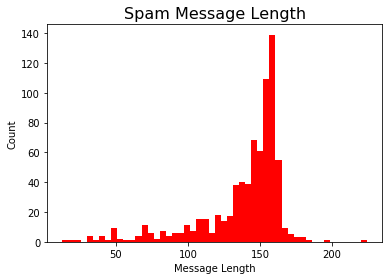

In [52]:
# Plotting length of sms text for spam sms
plt.hist(df[df['label']=='spam']['sms length'],color='red',bins=50)
plt.title('Spam Message Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

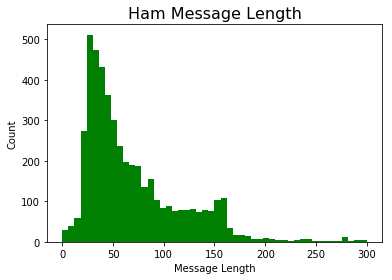

In [53]:
# Plotting length of sms text for spam sms
plt.hist(df[df['label']=='ham']['sms length'],color='green',bins=50,range=(0,300))
plt.title('Ham Message Length',fontsize=16)
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

#### Inference
We can see that sms with longer text tend to be spam.

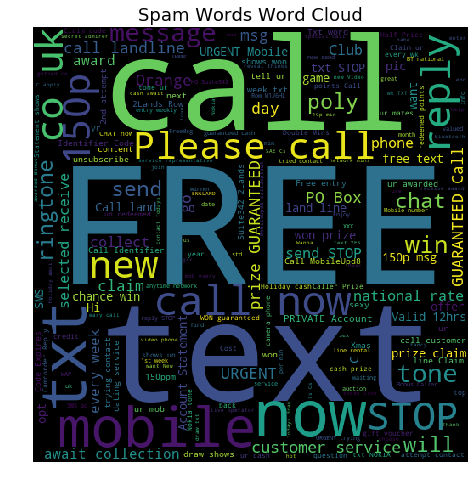

In [54]:
spam_words = ' '.join(list(df[df['label'] == 'spam']['sms']))
spam_wc = WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize=(15,8))
plt.imshow(spam_wc)
plt.axis("off")
plt.title("Spam Words Word Cloud",fontsize=18)
plt.show()

#### Inference
We can see that sms containing words FREE,Please Call, Now , Win tend to be very common spam words

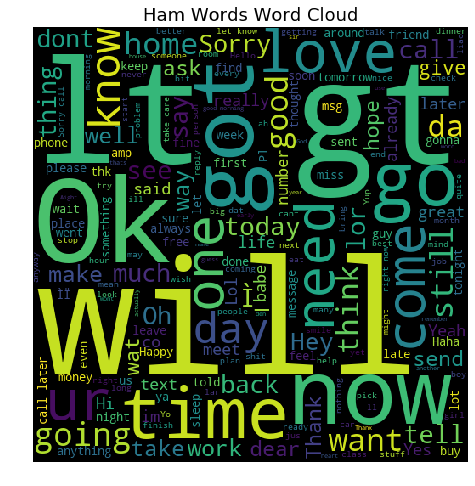

In [56]:
ham_words = ' '.join(list(df[df['label'] == 'ham']['sms']))
ham_wc = WordCloud(width=512,height=512).generate(ham_words)
plt.figure(figsize=(15,8))
plt.imshow(ham_wc)
plt.axis("off")
plt.title("Ham Words Word Cloud",fontsize=18)
plt.show()

#### Inference
We can see the most common ham sms contain words will, time, gt (got), come, know, sorry.

# 3. Text Preprocessing

In [58]:
#Processing Text - removing stopwords, punctuation and apply stemming
import string
ps = PorterStemmer()

def process_sms(sms):
    ''' This function removes punctuations and returns the sms as a list of words'''
    sms = sms.translate(str.maketrans('','',string.punctuation)) #remove punctuations
    sms = sms.split()
    sms = [ps.stem(word) for word in sms if len(word) > 2]
    sms = ' '.join(sms)
    return sms

In [59]:
df['sms'] = df.sms.apply(process_sms) #took about 2 mins to execute

In [60]:
# convert label to a numerical variable
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,sms,sms length
0,0,until jurong point crazi Avail onli bugi great...,111
1,0,lar Joke wif oni,29
2,1,Free entri wkli comp win Cup final tkt 21st Ma...,155
3,0,dun say earli hor alreadi then say,49
4,0,Nah dont think goe usf live around here though,61


### Using TF-IDF 
Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining.

TF means Term Frequency. It measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length as a way of normalization.

#### TF = (Number of times term w appears in a document) / (Total number of terms in the document)

Second part idf stands for Inverse Document Frequency. It measures how important a term is. While computing TF, all terms are equally important. However, it is known that certain terms, such as "may", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones.

#### IDF =  log_e(Total number of documents / Number of documents with term w in it)

##### Additive Smoothing:
So what if we encounter a word in test dataset which is not part of train dataset? In that case P(w) will be 0, which will make the P(spam|w) undefined (since we would have to divide by P(w) which is 0). To tackle this issue we introduce additive smoothing. In additive smoothing we add a number alpha to the numerator and add alpha times number of classes over which the probability is found in the denominator.

In [61]:
tfidf = TfidfVectorizer(encoding='latin-1',stop_words='english',analyzer='word',lowercase=True,smooth_idf=True)

In [62]:
#Splitting into train test set
X_train,X_test,y_train,y_test = train_test_split(df['sms'],df['label'],test_size = 0.30, random_state =7)

In [63]:
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)
print(type(features_train))
pd.DataFrame(features_train.todense(),columns=tfidf.get_feature_names())

<class 'scipy.sparse.csr.csr_matrix'>


,008704050406,0121,01223585236,01223585334,0125698789,020603,0207,02070836089,02073162414,02085076972,...,zouk,zyada,åòit,åômorrow,ìll,ìïll,ûªv,ûïharri,ûò,ûówel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Model Building

### Naive Bayes
Naive Bayes refers the the strong independence assumptions in the model, rather than the particular distribution of each feature. A Naive Bayes model assumes that each of the features it uses are conditionally independent of one another given some class. Generally, Naive Bayes works well on text data.

Multinomial Naive Bayes calculates likelihood to be count of an word/token (random variable) unlike Gaussian Naive Bayes and hence I would use Multinomial Naive Bayes model.

In [64]:
model = MultinomialNB()
model.fit(features_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [65]:
prediction = model.predict(features_test)
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

0.9521531100478469
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1444
           1       1.00      0.65      0.79       228

   micro avg       0.95      0.95      0.95      1672
   macro avg       0.97      0.82      0.88      1672
weighted avg       0.95      0.95      0.95      1672



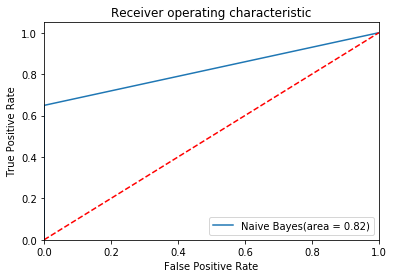

In [66]:
from sklearn import metrics 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

nb_roc_auc = roc_auc_score(y_test,prediction)
fpr, tpr, thresholds = roc_curve(y_test,prediction)
plt.figure()
plt.plot(fpr, tpr, label='Naive Bayes(area = %0.2f)' % nb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [67]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(features_train,y_train)
prediction_knn = model.predict(features_test)
print(accuracy_score(y_test,prediction_knn))
print(classification_report(y_test,prediction_knn))

0.9013157894736842
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1444
           1       1.00      0.28      0.43       228

   micro avg       0.90      0.90      0.90      1672
   macro avg       0.95      0.64      0.69      1672
weighted avg       0.91      0.90      0.88      1672



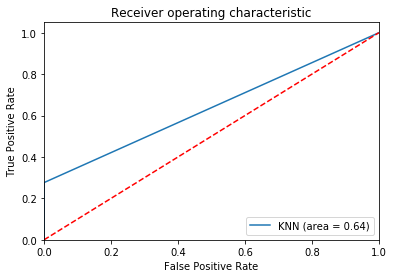

In [71]:
knn_roc_auc = roc_auc_score(y_test,prediction_knn)
fpr, tpr, thresholds = roc_curve(y_test,prediction_knn)
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Inference

We can see Naive Bayes performs the best with accuracy of 95% and ROC of 0.82